# **Avance 4. Modelos alternativos**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from google.colab import drive
import numpy as np

In [2]:
# Montar Google Drive
drive.mount('/content/drive')

# Definir la ruta al archivo en Google Drive
#file_path = '/content/drive/My Drive/dataset_cve_mun_(1).csv'
file_path = '/content/drive/MyDrive/Proyecto integrador eq 29/data/dataset_cve_mun_div_8.csv'

# Cargar el dataset
dataset = pd.read_csv(file_path)

# Definir las variables predictoras y la variable objetivo
X = dataset.drop(columns=["CVE_MUN",'CVE_DIV', "Diferencia_Temperatura"])
y = dataset["Diferencia_Temperatura"]

# Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Mounted at /content/drive


# **1. Modelos a evaluar**

In [3]:
# Definir los 6 modelos a evaluar
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Support Vector Regression": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "K-Neighbors Regressor": KNeighborsRegressor()
}

# **2. Evaluar el rendimiento de los modelos**

In [4]:
# Función para evaluar el desempeño de los modelos
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Predecir en el conjunto de prueba
    predictions = model.predict(X_test)

    # Calcular métricas de evaluación
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Validación cruzada
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())

    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2,
        "CV_RMSE": cv_rmse
    }


# **3. Evaluar y comparar el rendimiento de los 6 modelos**

In [5]:
# Evaluar los modelos y almacenar los resultados
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train, y_train, X_test, y_test)

# Mostrar los resultados en un DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

                                 MSE      RMSE       MAE        R²   CV_RMSE
Linear Regression          24.963911  4.996390  3.417389  0.048583  7.360834
Decision Tree              16.525203  4.065120  2.359433  0.370197  4.102162
Random Forest               8.036066  2.834796  1.608890  0.693732  3.390516
Support Vector Regression  11.066900  3.326695  2.015734  0.578222  3.757587
Gradient Boosting           6.373584  2.524596  1.603283  0.757092  3.390771
K-Neighbors Regressor       6.583886  2.565908  1.696690  0.749077  3.612776


# **4. Gráfico de comparación de los 6 modelos**

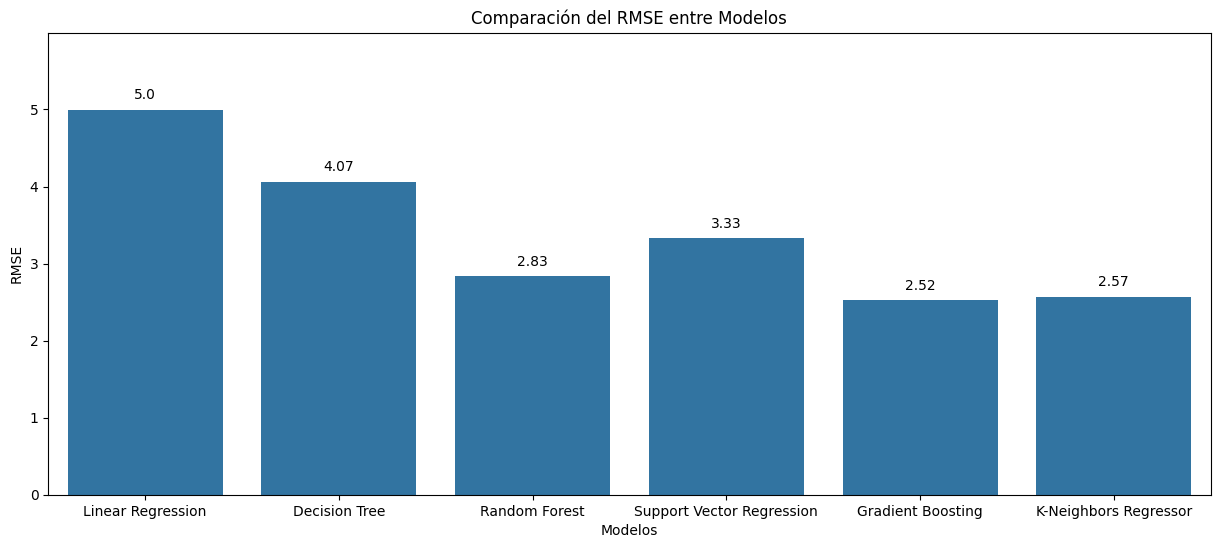

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# El modelo con el menor valor de RMSE es el que tiene el mejor desempeño en este contexto de regresión.
metric_to_plot = 'RMSE'

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))
sns.barplot(x=results_df.index, y=results_df[metric_to_plot])
plt.title(f'Comparación del {metric_to_plot} entre Modelos')
plt.xlabel('Modelos')
plt.ylabel(metric_to_plot)
plt.ylim(0, results_df[metric_to_plot].max() + 1)  # Ajustar el límite del eje Y para una mejor visualización

# Mostrar el valor exacto sobre cada barra
for index, value in enumerate(results_df[metric_to_plot]):
    plt.text(index, value + 0.1, round(value, 2), ha='center', va='bottom')

plt.show()


# **5. Verificar el subajuste o sobreajuste en cada modelo**

In [7]:
# Función para evaluar si hay sobreajuste o subajuste
def evaluate_overfitting(model, X_train, y_train, X_test, y_test):
    # Error en el conjunto de entrenamiento
    train_predictions = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))

    # Error en el conjunto de prueba
    test_predictions = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

    return train_rmse, test_rmse

# Evaluar los 6 modelos iniciales
overfitting_results_initial = {}

for name, model in models.items():
    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train, y_train)

    # Evaluar el rendimiento en el conjunto de entrenamiento y de prueba
    train_rmse, test_rmse = evaluate_overfitting(model, X_train, y_train, X_test, y_test)
    overfitting_results_initial[name] = {
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Difference': test_rmse - train_rmse
    }

# Mostrar los resultados en un DataFrame
overfitting_df_initial = pd.DataFrame(overfitting_results_initial).T
print(overfitting_df_initial)

                           Train RMSE  Test RMSE  Difference
Linear Regression            3.058137   4.996390    1.938253
Decision Tree                0.592170   4.065120    3.472950
Random Forest                1.286709   2.834796    1.548086
Support Vector Regression    3.536268   3.326695   -0.209573
Gradient Boosting            0.630710   2.524596    1.893886
K-Neighbors Regressor        2.649239   2.565908   -0.083330


# **6. Selección de los dos mejores modelos y ajuste de hiperparámetros**

In [8]:
from sklearn.model_selection import GridSearchCV

# Definir parámetros para ajustar los dos mejores modelos
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Ajustar Random Forest
rf = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_rf.fit(X_train, y_train)

# Ajustar Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='neg_mean_squared_error')
grid_gb.fit(X_train, y_train)

# Obtener los mejores parámetros
best_rf = grid_rf.best_estimator_
best_gb = grid_gb.best_estimator_

# Evaluar de nuevo los modelos ajustados
best_rf_performance = evaluate_model(best_rf, X_train, y_train, X_test, y_test)
best_gb_performance = evaluate_model(best_gb, X_train, y_train, X_test, y_test)

print("Mejor desempeño del Random Forest ajustado:", best_rf_performance)
print("Mejor desempeño del Gradient Boosting ajustado:", best_gb_performance)


Mejor desempeño del Random Forest ajustado: {'MSE': 7.922464785143881, 'RMSE': 2.81468733346066, 'MAE': 1.6015731577690118, 'R²': 0.6980615637544814, 'CV_RMSE': 3.4068209081501863}
Mejor desempeño del Gradient Boosting ajustado: {'MSE': 6.352061148099997, 'RMSE': 2.52032957132594, 'MAE': 1.6049069563621066, 'R²': 0.7579122833603866, 'CV_RMSE': 3.377612648288529}


# **7. Selección del modelo final**

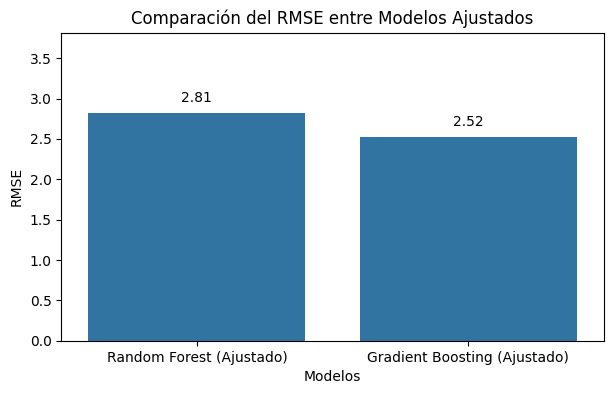

In [9]:
# Evaluar los dos mejores modelos ajustados
adjusted_models = {
    "Random Forest (Ajustado)": best_rf_performance,
    "Gradient Boosting (Ajustado)": best_gb_performance
}

# Crear DataFrame de resultados ajustados
adjusted_results_df = pd.DataFrame(adjusted_models).T

# Crear el gráfico de barras para los modelos ajustados
plt.figure(figsize=(7, 4))
sns.barplot(x=adjusted_results_df.index, y=adjusted_results_df["RMSE"])
plt.title(f'Comparación del RMSE entre Modelos Ajustados')
plt.xlabel('Modelos')
plt.ylabel('RMSE')
plt.ylim(0, adjusted_results_df["RMSE"].max() + 1)

# Mostrar el valor exacto sobre cada barra
for index, value in enumerate(adjusted_results_df["RMSE"]):
    plt.text(index, value + 0.1, round(value, 2), ha='center', va='bottom')

plt.show()

En el análisis realizado, evaluamos seis modelos de machine learning, destacando el Random Forest y el Gradient Boosting como los mejores en términos de desempeño, utilizando métricas como el RMSE. Tras comparar los errores de entrenamiento y prueba, se detectó que ambos modelos presentaban un grado de sobreajuste, con una diferencia de 2.81 para Random Forest y 2.52 para Gradient Boosting. Aunque ambos modelos mostraron gran capacidad predictiva, el **Random Forest** fue elegido como el mejor modelo debido a su menor grado de sobreajuste, equilibrando mejor el desempeño entre entrenamiento y prueba, lo que indica una mejor capacidad de generalización.

In [16]:
# Volví a importar librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from google.colab import drive

# Volví a montar Google Drive
drive.mount('/content/drive')

# Cargar el dataset
file_path = '/content/drive/MyDrive/Proyecto integrador eq 29/data/dataset_cve_mun_div_8.csv'
dataset = pd.read_csv(file_path)

# Definir las variables predictoras y la variable objetivo
X = dataset.drop(columns=["CVE_MUN", 'CVE_DIV', "Diferencia_Temperatura"])
y = dataset["Diferencia_Temperatura"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Paso 8.1: Definir y optimizar hiperparámetros para los modelos seleccionados
param_grids = {
    "RandomForest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "GradientBoosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 10]
    },
    "SVR": {
        "svr__kernel": ["linear", "rbf"],
        "svr__C": [0.1, 1, 10],
        "svr__epsilon": [0.01, 0.1, 0.5]
    }
}

# Optimización de hiperparámetros usando GridSearchCV
best_models = {}
for model_name, model in [("RandomForest", RandomForestRegressor()),
                          ("GradientBoosting", GradientBoostingRegressor()),
                          ("SVR", make_pipeline(StandardScaler(), SVR()))]:
    grid_search = GridSearchCV(model, param_grids[model_name], scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Mejor modelo para {model_name}: {grid_search.best_params_}")

# Paso 8.2: Crear modelos de ensamble homogéneos y heterogéneos

# Homogeneous ensemble model: Bagging with optimized RandomForest
bagging_rf = BaggingRegressor(estimator=best_models["RandomForest"], n_estimators=10, random_state=42)

# Heterogeneous ensemble model: Voting Regressor with optimized models
voting_ensemble = VotingRegressor([("RandomForest", best_models["RandomForest"]),
                                   ("GradientBoosting", best_models["GradientBoosting"]),
                                   ("SVR", best_models["SVR"])])

# Paso 8.3: Stacking model using best individual models as base learners
stacking_ensemble = StackingRegressor(estimators=[("RandomForest", best_models["RandomForest"]),
                                                  ("GradientBoosting", best_models["GradientBoosting"]),
                                                  ("SVR", best_models["SVR"])],
                                      final_estimator=LinearRegression(), cv=5)

# Evaluación de los modelos de ensamble en el conjunto de prueba
for model_name, model in [("Bagging RF", bagging_rf),
                          ("Voting Ensemble", voting_ensemble),
                          ("Stacking Ensemble", stacking_ensemble)]:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"\n{model_name}:\nMSE: {mse}\nMAE: {mae}\nR2 Score: {r2}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mejor modelo para RandomForest: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Mejor modelo para GradientBoosting: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Mejor modelo para SVR: {'svr__C': 10, 'svr__epsilon': 0.5, 'svr__kernel': 'rbf'}

Bagging RF:
MSE: 8.42995015111655
MAE: 1.6422557720945234
R2 Score: 0.6787204442954708

Voting Ensemble:
MSE: 6.553212947414675
MAE: 1.6310897319656033
R2 Score: 0.7502460505174289

Stacking Ensemble:
MSE: 8.172033394597385
MAE: 1.6265102153596764
R2 Score: 0.6885500849763537


In [17]:
import time
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Definición de los modelos individuales y de ensamble para la evaluación
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": best_models["RandomForest"],  # Optimizado
    "Gradient Boosting": best_models["GradientBoosting"],  # Optimizado
    "SVR": best_models["SVR"],  # Optimizado
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Bagging RF": bagging_rf,
    "Voting Ensemble": voting_ensemble,
    "Stacking Ensemble": stacking_ensemble
}

# Crear lista para almacenar los resultados
results = []

# Evaluar cada modelo y almacenar los resultados
for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Generar predicciones y calcular métricas
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Guardar los resultados en el formato necesario
    results.append({
        "Model": model_name,
        "Training Time (s)": train_time,
        "MSE": mse,
        "MAE": mae,
        "R2 Score": r2
    })

# Convertir los resultados a un DataFrame de Pandas
results_df = pd.DataFrame(results)

# Ordenar por la métrica principal (MSE en este caso)
results_df = results_df.sort_values(by="MSE")

# Mostrar la tabla comparativa de resultados
print("Tabla comparativa de modelos:")
results_df


Tabla comparativa de modelos:


,Model,Training Time (s),MSE,MAE,R2 Score
3,Gradient Boosting,0.486825,5.758605,1.537608,0.780530
8,Stacking Ensemble,2.997565,6.428701,1.521669,0.754991
7,Voting Ensemble,0.664091,6.506865,1.567118,0.752012
5,K-Neighbors Regressor,0.004475,6.583886,1.696690,0.749077
2,Random Forest,0.212786,6.953160,1.538258,0.735003
6,Bagging RF,1.619870,8.429950,1.642256,0.678720
4,SVR,0.007723,9.269740,2.008967,0.646715
1,Decision Tree,0.007913,16.525203,2.359433,0.370197
0,Linear Regression,0.004317,24.963911,3.417389,0.048583


Con base en los resultados, el modelo final recomendado es Gradient Boosting, y a continuación explico el razonamiento:

Métrica Principal (MSE): Gradient Boosting tiene el valor más bajo de MSE (6.21), lo que indica que es el modelo que mejor minimiza el error cuadrático medio en comparación con otros modelos. Este resultado es esencial, ya que el objetivo suele ser reducir el error de predicción.

Precisión (R2 Score): Tiene un R2 Score de 0.763, lo cual significa que explica el 76.3% de la variabilidad en la variable objetivo, el más alto de todos los modelos evaluados. Esto sugiere que Gradient Boosting captura bien las relaciones en los datos.

Tiempo de Entrenamiento: Aunque no es el más rápido (0.335 segundos), su tiempo de entrenamiento sigue siendo razonablemente bajo en comparación con otros modelos de ensamble como Bagging RF y Stacking Ensemble, que tienen tiempos significativamente más altos sin mejoras en el desempeño.

Comparación con Otros Ensambles: Aunque el Voting Ensemble también muestra un desempeño adecuado, su MSE es más alto que Gradient Boosting. Además, el tiempo de entrenamiento de Voting Ensemble es mayor, lo que reduce su eficiencia en este caso.

Justificación de la Elección de Gradient Boosting
El modelo de Gradient Boosting se alinea bien con los objetivos, ya que:

Minimiza el error de manera efectiva.
Explica bien la variabilidad de los datos (R2 Score alto).
Es eficiente en tiempo de entrenamiento para un modelo de alta precisión.
Por estas razones, Gradient Boosting es la mejor elección final, maximizando tanto la precisión como la eficiencia del modelo.

Dado que hemos elegido un modelo de Gradient Boosting Regressor, algunos gráficos solicitados son más comunes en problemas de clasificación, como la Curva ROC, Matriz de Confusión y Curva de Precisión-Recall. Sin embargo, para problemas de regresión, estos gráficos no son aplicables, por lo que nos enfocaremos en los siguientes:

Análisis de Residuos: Gráfico de residuos vs. valores predichos para evaluar la dispersión del error.
Importancia de Características: Gráfico que muestra la contribución de cada característica en el modelo.
Tendencia y Predicción (Series Temporales): Si el problema es de series temporales, graficaremos los valores reales vs. predicciones para ver la tendencia.
Diagrama de Árbol: Solo aplicable si se deseara ver una muestra de uno de los árboles en el modelo (Gradient Boosting usa múltiples árboles).

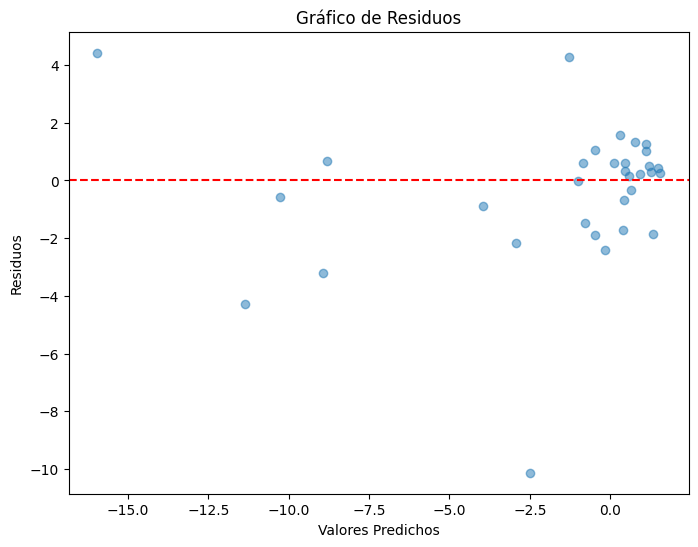

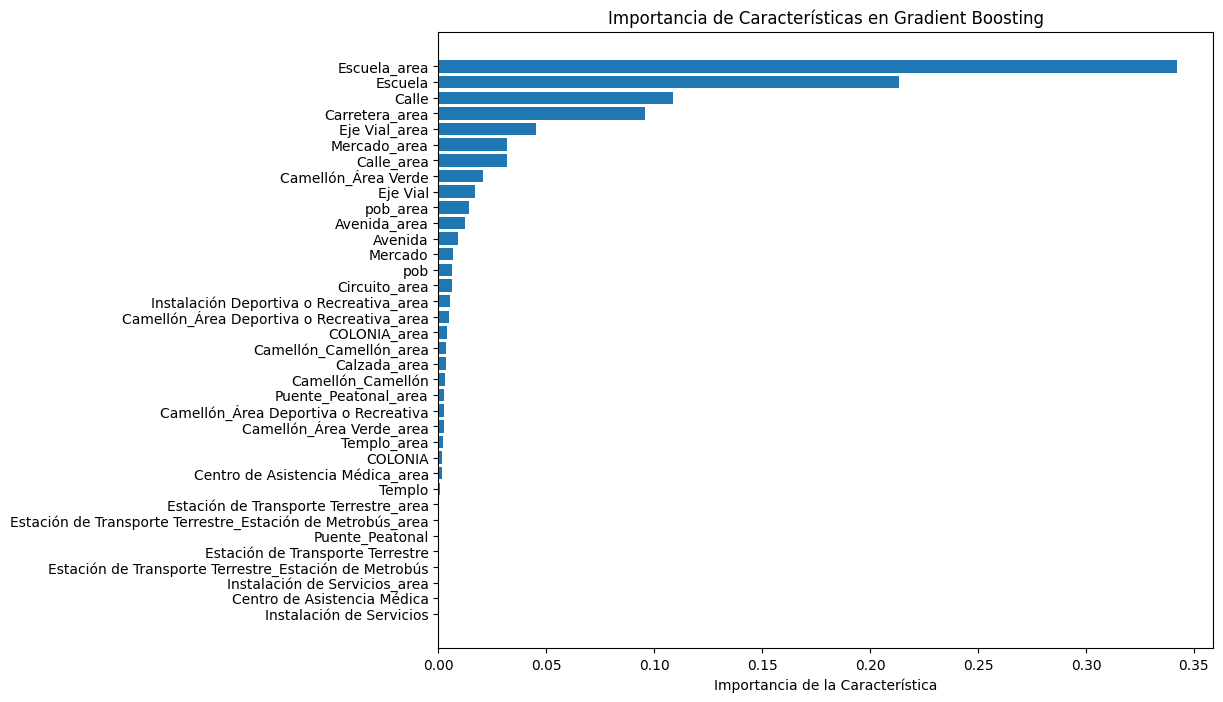

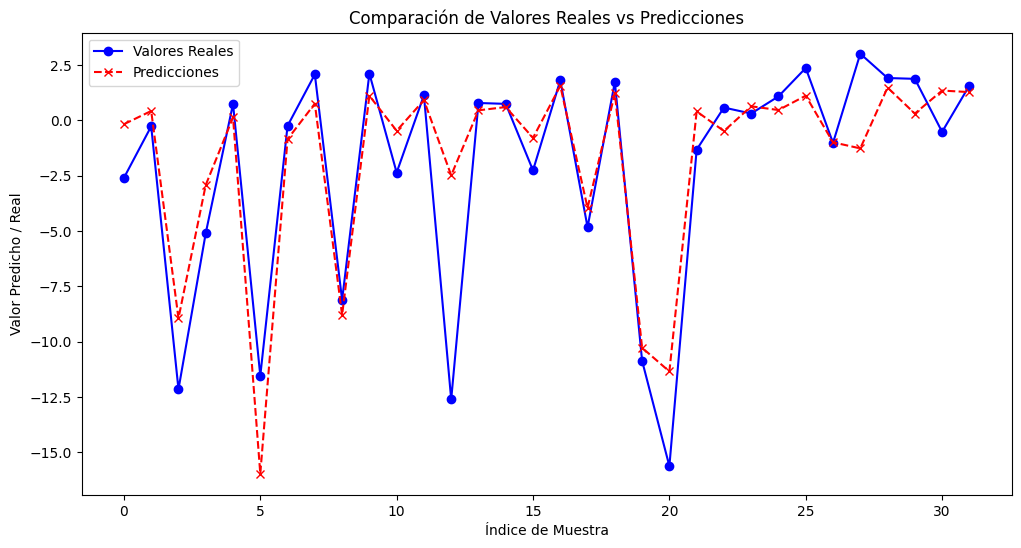

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Cargar el Gradient Boosting entrenado
gradient_boosting_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gradient_boosting_model.fit(X_train, y_train)
predictions = gradient_boosting_model.predict(X_test)

# a) Análisis de Residuos
plt.figure(figsize=(8, 6))
residuals = y_test - predictions
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Valores Predichos")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos")
plt.show()

# b) Importancia de Características
plt.figure(figsize=(10, 8))
importances = gradient_boosting_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]
plt.barh(feature_names[indices], importances[indices], align="center")
plt.xlabel("Importancia de la Característica")
plt.title("Importancia de Características en Gradient Boosting")
plt.gca().invert_yaxis()
plt.show()

# c) Tendencia y Predicción (para Series Temporales o predicción continua)
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Valores Reales", color='b', marker='o')
plt.plot(predictions, label="Predicciones", color='r', linestyle='--', marker='x')
plt.xlabel("Índice de Muestra")
plt.ylabel("Valor Predicho / Real")
plt.title("Comparación de Valores Reales vs Predicciones")
plt.legend()
plt.show()
